# Task 1.2 Data Preparation
*Alberto Roberto Marinelli, Giacomo Cignoni, Alessandro Bucci*
## Importing Libraries
First we import the libraries necessary to process the data

In [7]:
import math
import sys
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn import decomposition

Then we load the cleaned dataset adn the users datset

In [8]:
df_cleaned = pd.read_csv('../dataset/cleaned_joined_tweets.csv', sep=',', index_col=0) # Load cleaned dataset
df_users = pd.read_csv('../dataset/users.csv', sep=',', index_col=0)  # load users

And we set pandas options


In [9]:
pd.set_option('mode.use_inf_as_na', True) #Set the inf values as pd.NA
pd.set_option('max_info_rows',12_000_000)


In [10]:
df_cleaned.created_at = pd.to_datetime(df_cleaned.created_at)
df_cleaned.text = df_cleaned.text.astype('string')
df_cleaned.lang = pd.Categorical(df_cleaned.lang)

df_users.name = df_users.name.astype('string')
df_users.created_at = pd.to_datetime(df_users.created_at)
df_users.lang = pd.Categorical(df_users.lang)

In [11]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 2353593986 to 933183398
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   name            11507 non-null  string        
 1   lang            11508 non-null  category      
 2   bot             11508 non-null  int64         
 3   created_at      11508 non-null  datetime64[ns]
 4   statuses_count  11109 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), string(1)
memory usage: 462.0 KB


In [12]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11277758 entries, 0 to 11277757
Data columns (total 14 columns):
 #   Column           Non-Null Count     Dtype         
---  ------           --------------     -----         
 0   user_id          11277758 non-null  int64         
 1   id               10901728 non-null  float64       
 2   retweet_count    11277758 non-null  int64         
 3   reply_count      11277758 non-null  int64         
 4   favorite_count   11277758 non-null  int64         
 5   num_hashtags     11277758 non-null  int64         
 6   num_urls         11277758 non-null  int64         
 7   num_mentions     11277758 non-null  int64         
 8   created_at       11277758 non-null  datetime64[ns]
 9   text             10860709 non-null  string        
 10  lang             11277758 non-null  category      
 11  bot              11277758 non-null  bool          
 12  created_at_user  11277758 non-null  object        
 13  statuses_count   11277758 non-null  int6

## Plot graphics and correlation map

## Functions used to extract indicators

In [13]:
min_date = np.datetime64('2006-07-15 00:00:00') # Twitter creation year, used to check if a tweet is published after the creation of twitter
max_date = np.datetime64('2020-12-31 23:59:59') # Data scraping year, used to check if a tweet is published before the data scraping

def get_tweet_outside_of_possible_publishing_years(indicators_dataframe, user_id, tweet):
    if tweet.created_at < min_date or tweet.created_at > max_date:  # if the tweet is outside of the publishable period of time
        return 1
    else:
        return 0

In [14]:
def get_number_of_likes(tweet):
    try:
        return np.int64(tweet['favorite_count'])
    except:
        return 0

In [15]:
def tweet_with_text_count(indicators_dataframe, user_id, tweet):
    tweet_len = len(str(tweet['text']))
    if tweet_len > 0:
        return 1
    else:
        return 0

In [16]:
def get_avg_tweet_len(indicators_dataframe, user_id ,tweet):
    tweet_len = len(str(tweet['text']))
    previous_avg = indicators_dataframe.at[user_id, 'avg_tweet_len']

    if user_id not in indicators_dataframe.index or np.isnan(previous_avg): #if the user is not in the dataframe or the previous avg does not exist
        return tweet_len #it returns 0 if the len is 0, so if the tweet has no text

    elif tweet_len > 0: #if the tweet has a text, use it to calculate the avg tweet len
        tweet_count = indicators_dataframe.at[user_id, 'tweet_with_text_count']
        
        # summing the previous average multiplied for n/n+1 with the current tweet length multiplied for
        # 1/n+1 gives us the current average where n is the previous tweet count
        avg_tweet_len = previous_avg * ((tweet_count - 1) / tweet_count) \
                        + tweet_len * (1 / tweet_count)

        return avg_tweet_len
    else: #otherwise return the previous avg
        return previous_avg



In [17]:
def set_indicators(indicators_dataframe, user_id, tweet):
    # if a user published a tweet and is not into the dataframe
    if user_id not in indicators_dataframe.index:
        # tweet count is set to 1 and the average length is the length of the sole tweet published
        #Assign to the indicator dataframe
        indicators_dataframe.at[user_id, 'tweet_count'] = 1
        indicators_dataframe.at[user_id, 'tweet_with_text_count'] = tweet_with_text_count(indicators_dataframe, user_id, tweet)
        indicators_dataframe.at[user_id, 'total_num_of_likes'] = get_number_of_likes(tweet)
        indicators_dataframe.at[user_id, 'avg_tweet_len'] = get_avg_tweet_len(indicators_dataframe, user_id ,tweet)
        indicators_dataframe.at[user_id, 'tweet_outside_of_possible_publishing_years'] = get_tweet_outside_of_possible_publishing_years(indicators_dataframe,user_id,tweet)

    # if a user published a tweet and is into the dataframe
    else:
        #Update to the indicator dataframe
        indicators_dataframe.at[user_id, 'tweet_count'] += 1
        indicators_dataframe.at[user_id, 'tweet_with_text_count'] += tweet_with_text_count(indicators_dataframe, user_id, tweet)
        indicators_dataframe.at[user_id, 'total_num_of_likes'] += get_number_of_likes(tweet)
        indicators_dataframe.at[user_id, 'avg_tweet_len'] = get_avg_tweet_len(indicators_dataframe, user_id ,tweet)
        indicators_dataframe.at[user_id, 'tweet_outside_of_possible_publishing_years'] += get_tweet_outside_of_possible_publishing_years(indicators_dataframe,user_id,tweet)

In [18]:
def get_ratios(indicators_dataframe):
    for id_user, user in tqdm(indicators_dataframe.iterrows(),desc='Getting ratios',total=len(indicators_dataframe)):
        # tweet count is always >0, so there is no risk of a zero division
        user['like_ratio_per_tweet'] = user['total_num_of_likes'] / user['tweet_count']

### Entropy extraction functions

In [19]:
#The threshold is needed to consider a meaningful number of tweets for applying the entropy
entropy_threshold = 10

def get_entropy_dict_from_timedeltas(dict_of_dict_of_timedeltas):
    entropy_dict = dict()
    for user_id in tqdm(dict_of_dict_of_timedeltas,desc='Getting user\'s entropy from timedeltas',total=len(dict_of_dict_of_timedeltas)):
        dict_of_timedeltas_of_the_user = dict_of_dict_of_timedeltas[user_id]
        total_number_of_timedeltas = sum(dict_of_timedeltas_of_the_user.values()) #the total number of timedeltas appeared
        if total_number_of_timedeltas >= entropy_threshold:
            entropy = 0. #entropy set to 0.
            for timedelta in dict_of_timedeltas_of_the_user:
                number_of_timedelta = dict_of_timedeltas_of_the_user[timedelta] #the number of times the unique timedelta has appeared
                #The probability of a timedelta to appear is the number of times the unique timedelta has appeared over total number of times timedeltas appeared
                entropy -= number_of_timedelta/total_number_of_timedeltas * np.log2(number_of_timedelta/total_number_of_timedeltas) #shannon's entropy

            entropy_dict[user_id] = entropy
        else:
            entropy_dict[user_id] = np.nan
    return entropy_dict

In [20]:
def apply_time_precision(timedelta, time_precision='second'):
    if time_precision=='minute':
        return timedelta.round(freq='min') # approximate to nearest minute
    elif time_precision=='15minutes':
        return timedelta.round(freq='15min') # approximate to nearest 15 minutes
    elif time_precision=='hour':
        return timedelta.round(freq='h') # approximate to nearest hour
    elif time_precision=='day': 
        return timedelta.round(freq='D') # approximate to nearest day
    else:
        return timedelta.round(freq='s') # # approximate to nearest second (default)

In [21]:
def get_timedelta_list_per_user(time_precision='second'):
    df_cleaned.sort_values(by="created_at",inplace=True) # is needed to be sorted by date in order to be able to subtract the previous date from the current

    last_tweet_encountered = dict() #a dict where the key is user_id and the value is the last post datetime64. It is needed to get the timedelta between posts
    tweet_timedeltas = dict() #a dict where the key is user_id and the value is a dict containing the timedeltas:number_of_times_timedelta_encountered

    for _, tweet in tqdm(df_cleaned.iterrows(),desc='Getting timedeltas list with '+time_precision+' precision', total=len(df_cleaned)): #iterating on rows
        try: #if user_id cannot be casted into int64 it skips the tweet
            user_id = np.int64(tweet['user_id'])
        except:
            continue

        if user_id not in tweet_timedeltas.keys(): # if user is not into the timedeltas
            last_tweet_encountered[user_id] = tweet.created_at #the first datetime is saved
            tweet_timedeltas[user_id] = dict() #the dict containing timedelta:number_of_times_timedelta_encountered is created
        else:
            timedelta = tweet.created_at - last_tweet_encountered[user_id] #subrtacting the previous datetime64 to the current datetime64 gives the timedelta between the 2
            timedelta = apply_time_precision(timedelta, time_precision) #approximate the time to the nearest timedelta given the precision
            last_tweet_encountered[user_id] = tweet.created_at # the last datetime64 is saved
            if timedelta not in tweet_timedeltas[user_id]: # if the timedelta is not in the dict containing timedelta:number_of_times_timedelta_encountered
                tweet_timedeltas[user_id][timedelta] = 1 # it is the first timedelta, so it has appeared only 1 time
            else:
                tweet_timedeltas[user_id][timedelta] += 1 # it has already appeared, so the number of times encountered increases by 1
    
    return tweet_timedeltas

In [22]:
def get_entropy_over_time(time_precision='second'):
    #Subtract from each datetime the previous datetime, obtaining the timedeltas.
    #Calculate the entropy on those timedeltas (if the timedeltas are the same, the entropy will be lower)
    
    list_of_timedeltas = get_timedelta_list_per_user(time_precision)
    user_entropy_dict = get_entropy_dict_from_timedeltas(list_of_timedeltas) # a dict where the key is user_id and the value is the entropy of the user

    df_entropy = pd.DataFrame(columns=['user_id', 'entropy_'+time_precision])

    #saving the dict as a dataframe
    index = 0
    for user_id in tqdm(user_entropy_dict,desc='Converting dict to dataframe',total=len(user_entropy_dict)): 
        df_entropy.at[index, 'user_id'] = user_id
        df_entropy.at[index, 'entropy_'+time_precision] = user_entropy_dict[user_id]
        index += 1
    
    df_entropy['user_id'] = df_entropy['user_id'].astype('Int64')
    df_entropy['entropy_'+time_precision] = df_entropy['entropy_'+time_precision].astype('Float64')
    
    return df_entropy
    

## Extracting indicators
Indicators per user covered: 

* total number of tweets    
* average tweet length, 
* total number of likes, 
* like ratio per tweet,
* counter of tweets outside of possible publishing years
* entropy peer user with second wise precision

In [23]:
def get_indicators_csv():
    # create a dataframe for storing indicators
    df_indicators = pd.DataFrame(columns=['tweet_count', 'tweet_with_text_count', 'avg_tweet_len', 'total_num_of_likes', 'like_ratio_per_tweet', 'tweet_outside_of_possible_publishing_years'])
    # setting the index column name to 'id'
    df_indicators.index.names = ['user_id']
    print('Starting extraction of indicators')
    # iterating on tweets
    for index, tweet in tqdm(df_cleaned.iterrows(), desc='Indicators extraction', total=len(df_cleaned)):
        try: #if user_id cannot be casted into int64 it skips the tweet
            user_id = np.int64(tweet['user_id'])
        except:
            continue
        set_indicators(df_indicators, user_id, tweet)

    print('Getting ratios')
    # ratios
    get_ratios(df_indicators)

    print('Gettting entropies')
    
    for time_precision in {'second','minute','15minutes','hour','day'}:
        df_entropy = get_entropy_over_time(time_precision=time_precision)
        df_indicators = pd.merge(df_indicators, df_entropy, how='inner', left_on='user_id', right_on='user_id')

    # save csv with indicators
    df_indicators.to_csv('../dataset/indicators.csv')
    return df_indicators

In [24]:
indicators = get_indicators_csv()


Starting extraction of indicators


Indicators extraction:   0%|          | 0/11277758 [00:00<?, ?it/s]

Getting ratios


Getting ratios:   0%|          | 0/11508 [00:00<?, ?it/s]

Gettting entropies


Getting timedeltas list with day precision:   0%|          | 0/11277758 [00:00<?, ?it/s]

Getting user's entropy from timedeltas:   0%|          | 0/11508 [00:00<?, ?it/s]

Converting dict to dataframe:   0%|          | 0/11508 [00:00<?, ?it/s]

Getting timedeltas list with second precision:   0%|          | 0/11277758 [00:00<?, ?it/s]

Getting user's entropy from timedeltas:   0%|          | 0/11508 [00:00<?, ?it/s]

Converting dict to dataframe:   0%|          | 0/11508 [00:00<?, ?it/s]

Getting timedeltas list with minute precision:   0%|          | 0/11277758 [00:00<?, ?it/s]

Getting user's entropy from timedeltas:   0%|          | 0/11508 [00:00<?, ?it/s]

Converting dict to dataframe:   0%|          | 0/11508 [00:00<?, ?it/s]

Getting timedeltas list with 15minutes precision:   0%|          | 0/11277758 [00:00<?, ?it/s]

Getting user's entropy from timedeltas:   0%|          | 0/11508 [00:00<?, ?it/s]

Converting dict to dataframe:   0%|          | 0/11508 [00:00<?, ?it/s]

Getting timedeltas list with hour precision:   0%|          | 0/11277758 [00:00<?, ?it/s]

Getting user's entropy from timedeltas:   0%|          | 0/11508 [00:00<?, ?it/s]

Converting dict to dataframe:   0%|          | 0/11508 [00:00<?, ?it/s]

In [26]:
indicators.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 12 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   user_id                                     11508 non-null  int64  
 1   tweet_count                                 11508 non-null  object 
 2   tweet_with_text_count                       11508 non-null  object 
 3   avg_tweet_len                               11508 non-null  object 
 4   total_num_of_likes                          11508 non-null  object 
 5   like_ratio_per_tweet                        11508 non-null  object 
 6   tweet_outside_of_possible_publishing_years  11508 non-null  object 
 7   entropy_day                                 11085 non-null  Float64
 8   entropy_second                              11085 non-null  Float64
 9   entropy_minute                              11085 non-null  Float64
 10  entropy_15

In [41]:

df_users_indicators = pd.merge(df_users,indicators,left_index=True,right_on='user_id', how='inner')
df_users_indicators.drop(columns='tweet_with_text_count',inplace=True)
df_users_indicators = df_users_indicators.convert_dtypes()
df_users_indicators.set_index('user_id',inplace=True)
df_users_indicators.to_csv('../dataset/user_indicators.csv')

## Correlation map on indicators

Now we visualize the correlation matrix to highlist the correlation between the attributes

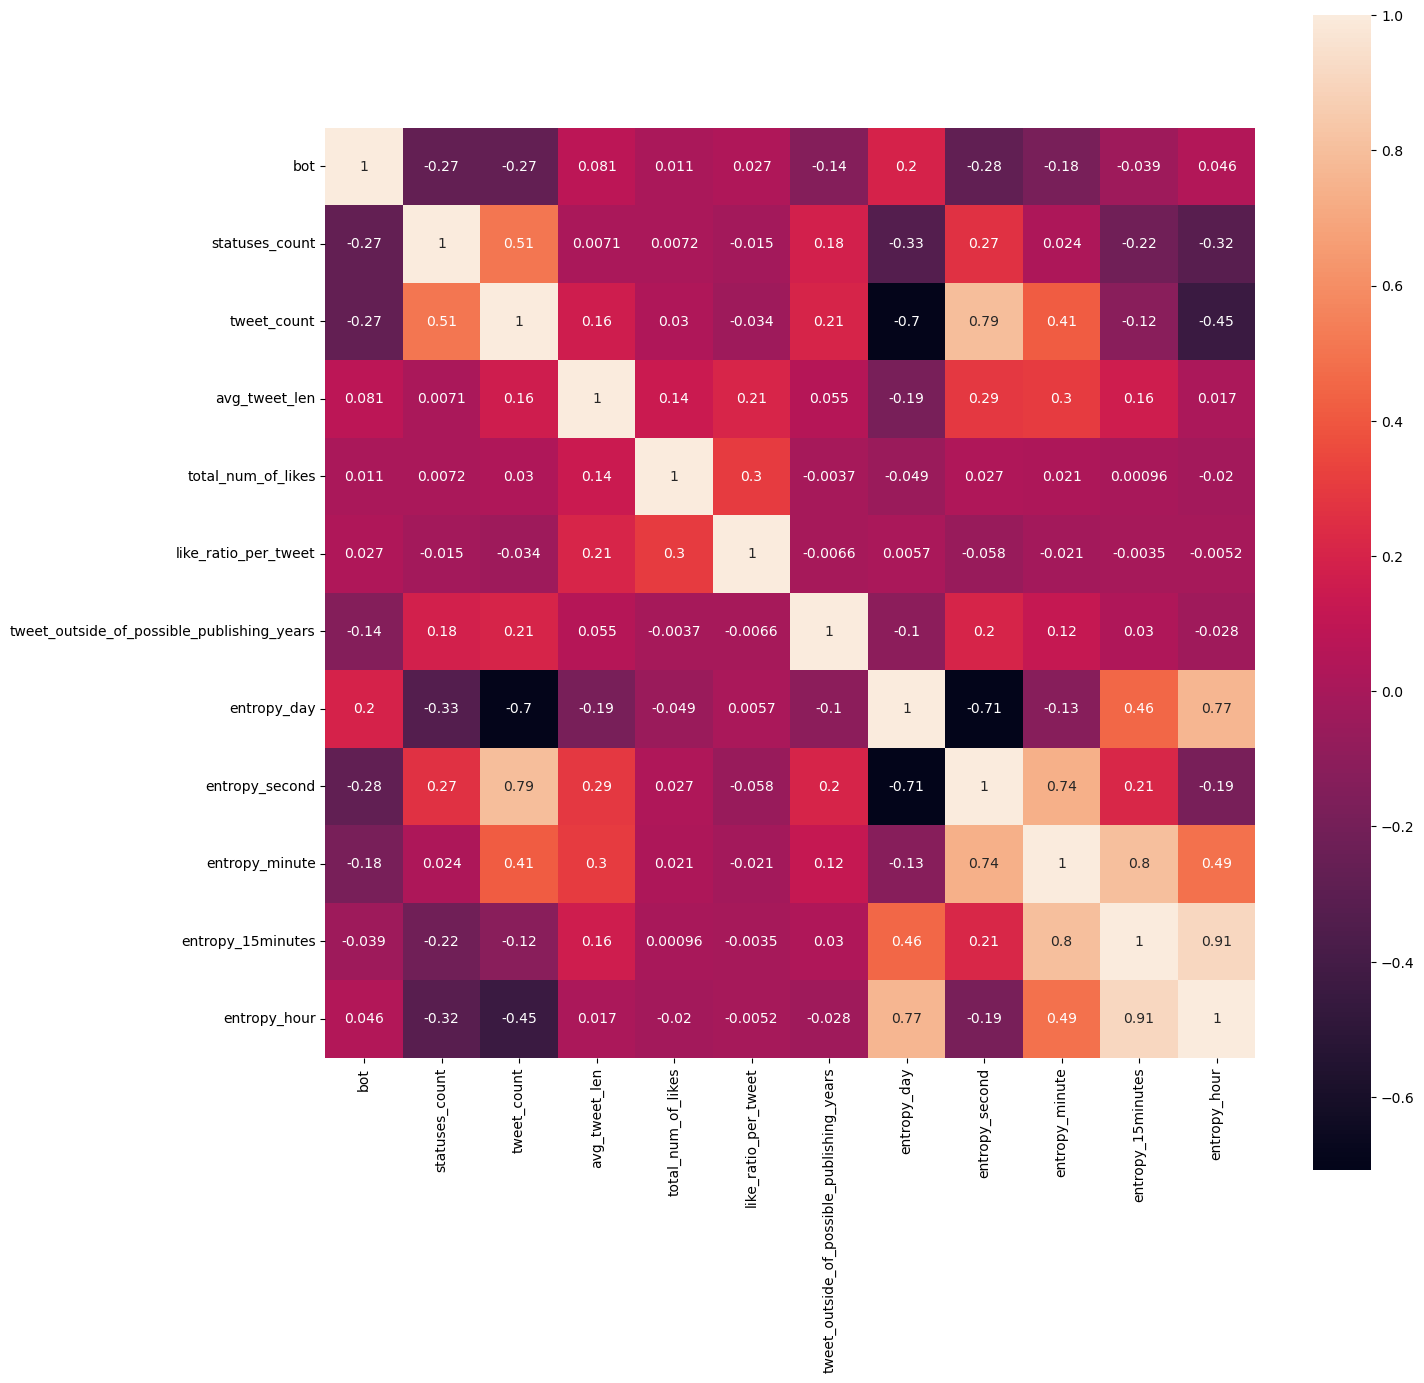

In [42]:
corr_matrix = df_users_indicators.corr()

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask
sn.heatmap(corr_matrix, annot=True, square=True)

plt.show()